# Training the REAL/FAKE classifier

In [1]:
from fastai.core import *
from fastai.vision import *
from fastai.callbacks import *
from efficientnet_pytorch import EfficientNet

## Data

In [2]:
path = Path('../data/cropped_faces/')

#### `SplitData` if using online selection model

dfdcs 5, 10, 35, and 40 are used in online selection, so if you're using these models, you should exclude face crops from these dfdcs.

In [3]:
_dfdcs, dfdcs = [5, 10, 35], [40,]

In [4]:
ant = pd.read_csv(path/'train.csv')
ant['dfdc'] = ant.directory.apply(lambda o: int(o.split('_')[-1]))
ovns = ant.set_index('dfdc').loc[_dfdcs + dfdcs].fname.unique()

`ovns` are the names of the videos which should be excluded.

In [5]:
train_items = get_image_files(path/'train')
len(train_items)

84328

In [6]:
train_items = [o for o in train_items if o.name.split('_')[0] not in ovns]
len(train_items)

81747

In [7]:
valid_items = get_image_files(path/'valid')

In [8]:
src = ImageList(train_items).split_none()
src.valid = ImageList(valid_items)

#### `SplitData` if not using online selection model

In [12]:
src = ImageList.from_folder(path).split_by_folder(train='train', valid='valid')

### Create `DataBunch`

In [9]:
def get_data(bs,size):
    data = (src.label_from_re('([A-Z]+).jpg$')
           .transform(get_transforms(max_warp=0, max_zoom=1), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    return data

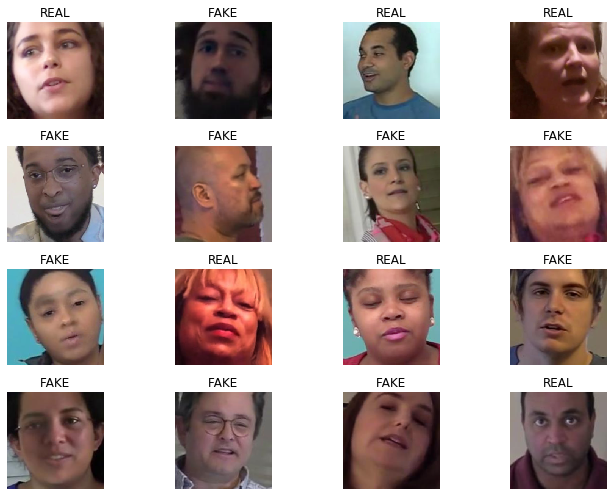

In [11]:
bs, sz = 32, 256
data = get_data(bs, sz)
data.show_batch(rows=4, figsize=(10,7))

## Resnet

In [ ]:
model = models.resnet18(num_classes=2)

In [ ]:
import copy

In [ ]:
fc = copy.deepcopy(model.fc)

In [ ]:
model.fc = nn.Identity()

In [ ]:
state_dict = torch.load('models/resnet_oselect_dfdc.pth')
model.load_state_dict(state_dict['model'])

<All keys matched successfully>

In [ ]:
model.fc = fc

In [ ]:
model.fc

Linear(in_features=512, out_features=2, bias=True)

In [ ]:
learn = Learner(data, model, path='./', metrics=[accuracy])

In [ ]:
learn.lr_find(start_lr=1e-11, end_lr=1e-7)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


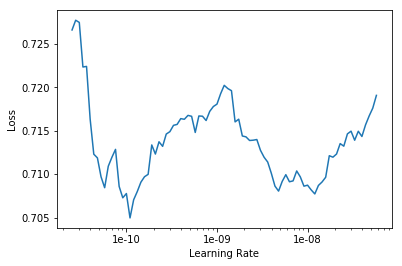

In [ ]:
learn.recorder.plot(skip_end=5)

In [ ]:
learn.fit_one_cycle(cyc_len=5, max_lr=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.711658,0.714238,0.500000,00:43
1,0.710710,0.706583,0.522500,00:41
2,0.703991,0.704125,0.492500,00:41
3,0.703532,0.702864,0.472500,00:43
4,0.700790,0.702296,0.485000,00:44


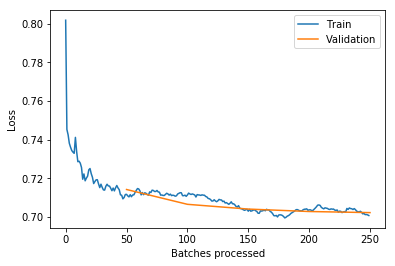

In [ ]:
learn.recorder.plot_losses()

## EfficientNetB0

### Transfer from Imagenet

In [65]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=data.train_dl.c)


Loaded pretrained weights for efficientnet-b0


In [66]:
learn = Learner(data, model, metrics=[accuracy])

In [67]:
#fm = flatten_model(model)
#learn.layer_groups = [nn.Sequential(*fm[:-3]), nn.Sequential(*fm[-3:])]

In [68]:
#learn.freeze_to(-1)

In [69]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


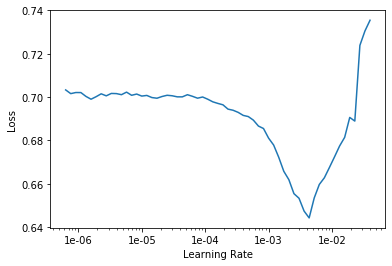

In [70]:
learn.recorder.plot(skip_end=15)

In [71]:
learn.fit_one_cycle(cyc_len=20, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.669000,0.705785,0.522500,00:12
1,0.546166,0.796264,0.572500,00:12
2,0.382067,0.801120,0.587500,00:12
3,0.297392,0.890991,0.655000,00:12
4,0.218553,1.139411,0.700000,00:12
5,0.220932,2.162415,0.622500,00:12
6,0.183045,1.362391,0.675000,00:12
7,0.143896,1.159336,0.665000,00:12
8,0.101916,1.913083,0.682500,00:12
9,0.089704,1.098780,0.685000,00:12


In [72]:
learn.save('effnetb0_classifier_ftimagenet')

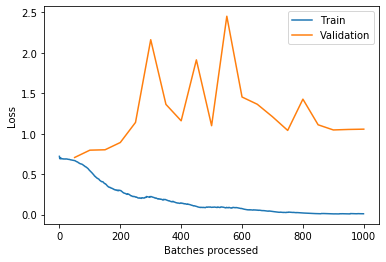

In [73]:
learn.recorder.plot_losses()

### Transfer from Online Selection

In [27]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=data.train_dl.c)


Loaded pretrained weights for efficientnet-b0


In [28]:
import copy

In [29]:
swish0 = copy.deepcopy(model._swish)
fc0 = copy.deepcopy(model._fc)
dropout0 = copy.deepcopy(model._dropout)

In [30]:
model._swish = nn.Identity()
model._fc = nn.Identity()
model._dropout = nn.Identity()

Specify which oneline selection model to fine-tune.

In [31]:
model_oselect = 'effnetb0_pairselect_margin1_9'

In [32]:
#state_dict = torch.load('models/effnetb0_oselect.pth')
state_dict = torch.load(f'models/{model_oselect}.pth')

In [33]:
model.load_state_dict(state_dict['model'])

<All keys matched successfully>

In [34]:
model._swish = swish0
model._fc = fc0
model._dropout = dropout0

In [35]:
learn = Learner(data, model, metrics=[accuracy])

In [36]:
# Discriminative learning.  DON"T WORK
#fm = flatten_model(model)
#learn.layer_groups = [nn.Sequential(*fm[:-3]), nn.Sequential(*fm[-3:])]

In [37]:
#learn.freeze_to(-1)

In [38]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


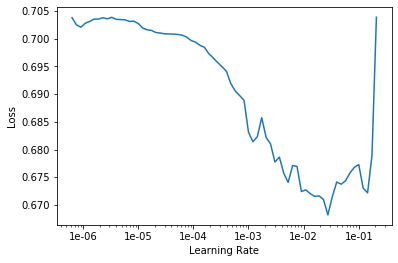

In [40]:
learn.recorder.plot(skip_end=8)

In [41]:
callbacks = [SaveModelCallback(learn, monitor='valid_loss', 
                               every='improvement', 
                               name=f'ft_{model_oselect}')]

In [42]:
learn.fit_one_cycle(cyc_len=30, max_lr=5e-4, callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,time
0,0.642253,0.657782,0.633883,08:22
1,0.636544,0.658826,0.633883,08:22
2,0.642007,0.656341,0.633883,08:21
3,0.635170,0.657136,0.633883,08:22
4,0.635763,0.639673,0.634398,08:23
5,0.636326,0.628042,0.654995,08:23
6,0.619182,0.627785,0.655510,08:23
7,0.598946,0.622375,0.663234,08:23
8,0.610881,0.617176,0.647786,08:22
9,0.594771,0.612458,0.651390,08:22


Better model found at epoch 0 with valid_loss value: 0.6577824354171753.
Better model found at epoch 2 with valid_loss value: 0.6563413143157959.
Better model found at epoch 4 with valid_loss value: 0.6396734714508057.
Better model found at epoch 5 with valid_loss value: 0.6280418634414673.
Better model found at epoch 6 with valid_loss value: 0.6277846693992615.
Better model found at epoch 7 with valid_loss value: 0.6223750710487366.
Better model found at epoch 8 with valid_loss value: 0.6171756386756897.
Better model found at epoch 9 with valid_loss value: 0.6124580502510071.
Better model found at epoch 13 with valid_loss value: 0.6098335385322571.
Better model found at epoch 14 with valid_loss value: 0.606499433517456.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Better model found at epoch 19 with valid_loss value: 0.5932510495185852.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Better model found at epoch 21 with valid_loss value: 0.5886067152023315.
Better model found at epoch 22 with valid_loss value: 0.5883517265319824.
Better model found at epoch 24 with valid_loss value: 0.5865144729614258.
Better model found at epoch 25 with valid_loss value: 0.5863669514656067.
Better model found at epoch 26 with valid_loss value: 0.5850085020065308.


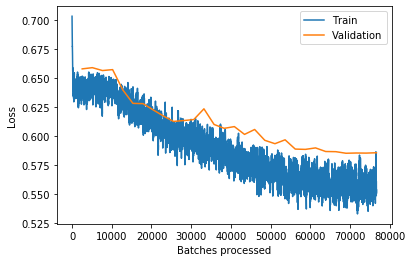

In [43]:
learn.recorder.plot_losses()

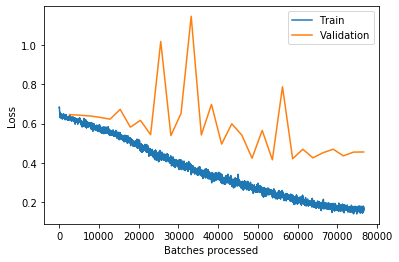

In [26]:
learn.recorder.plot_losses()

# -fin